# $XX$ all-to-all Ising interactions


In [2]:
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import ultraplot as uplt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.diagram import draw
from squint.ops.base import SharedGate
from squint.ops.dv import DiscreteVariableState, HGate, RXXGate, RZGate
from squint.utils import partition_op

In [3]:
dim = 2
n = 4

circuit = Circuit(backend="pure")

for i in range(n):
    circuit.add(DiscreteVariableState(wires=(i,), n=(0,)))

for i, j in itertools.combinations(list(range(n)), 2):
    circuit.add(RXXGate(wires=(i, j), angle=jnp.pi / 4))

circuit.add(
    SharedGate(op=RZGate(wires=(0,), phi=0.1 * jnp.pi), wires=tuple(range(1, n))),
    "phase",
)

for i in range(n):
    circuit.add(HGate(wires=(i,)))

pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteVariableState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   DiscreteVariableState(wires=(1,), n=[(1.0, (0,))]),
│   2:
│   DiscreteVariableState(wires=(2,), n=[(1.0, (0,))]),
│   3:
│   DiscreteVariableState(wires=(3,), n=[(1.0, (0,))]),
│   4:
│   RXXGate(wires=(0, 1), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   5:
│   RXXGate(wires=(0, 2), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   6:
│   RXXGate(wires=(0, 3), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   7:
│   RXXGate(wires=(1, 2), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   8:
│   RXXGate(wires=(1, 3), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   9:
│   RXXGate(wires=(2, 3), angles=weak_f64[], _basis_op_indices=(2, 2)),
│   'phase':
│   SharedGate(
│     wires=(0, 1, 2, 3),
│     op=RZGate(wires=(0,), phi=weak_f64[]),
│     copies=[
│   │   RZGate(wires=(1,), phi=None),
│   │   RZGate(wires=(2,), phi=None),
│   │   RZGate(wires=(3,), phi=None)
│     ],
│     where=<function <lambda>>,
│     get=<function <lambda>>
│   ),
│   11:
│   HGate(wires=(0,)),
│   12:
│   HGate(wires=(1,)),
│   13:
│   HGate(wires=(2,)),
│   14:
│   HGate(wires=(3,))
  },
  _backend='pure'
)

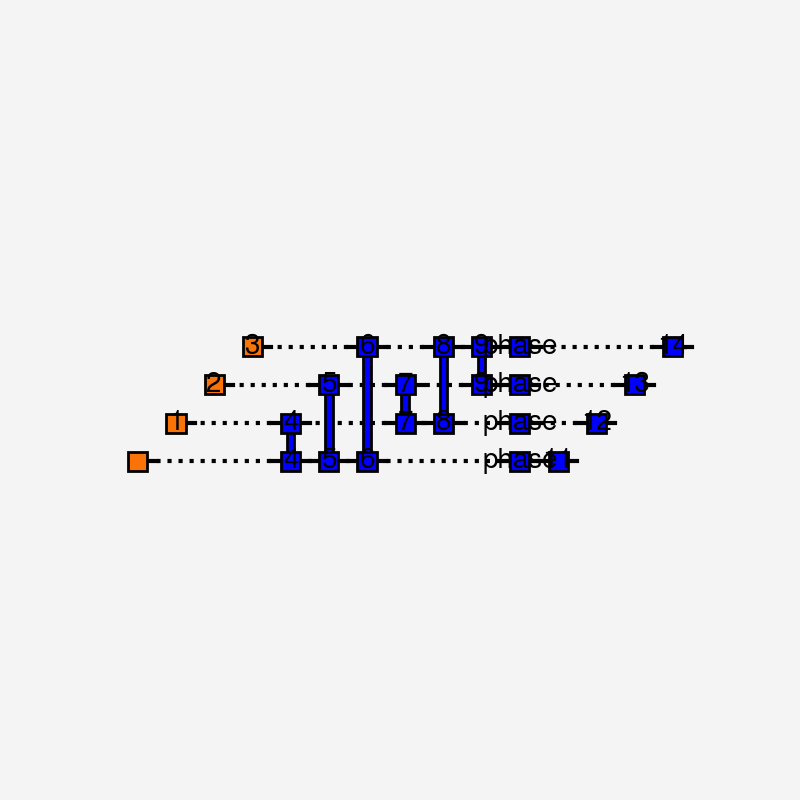

In [5]:
fig = draw(circuit)

In [7]:
params, static = partition_op(circuit, "phase")
sim = circuit.compile(static, dim, params, optimize="greedy").jit()

In [8]:
prob = sim.probabilities.forward(params)
dprob = sim.probabilities.grad(params)
cfi = sim.probabilities.cfim(params).squeeze()

print(f"CFI is {cfi}")

CFI is 15.999999999948939


In [9]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(lambda pytree: pytree.ops["phase"].op.phi, params, phis)

probs = jax.vmap(sim.probabilities.forward)(params)
grads = jax.vmap(sim.probabilities.grad)(params).ops["phase"].op.phi
qfims = jax.vmap(sim.amplitudes.qfim)(params)
cfims = jax.vmap(sim.probabilities.cfim)(params)

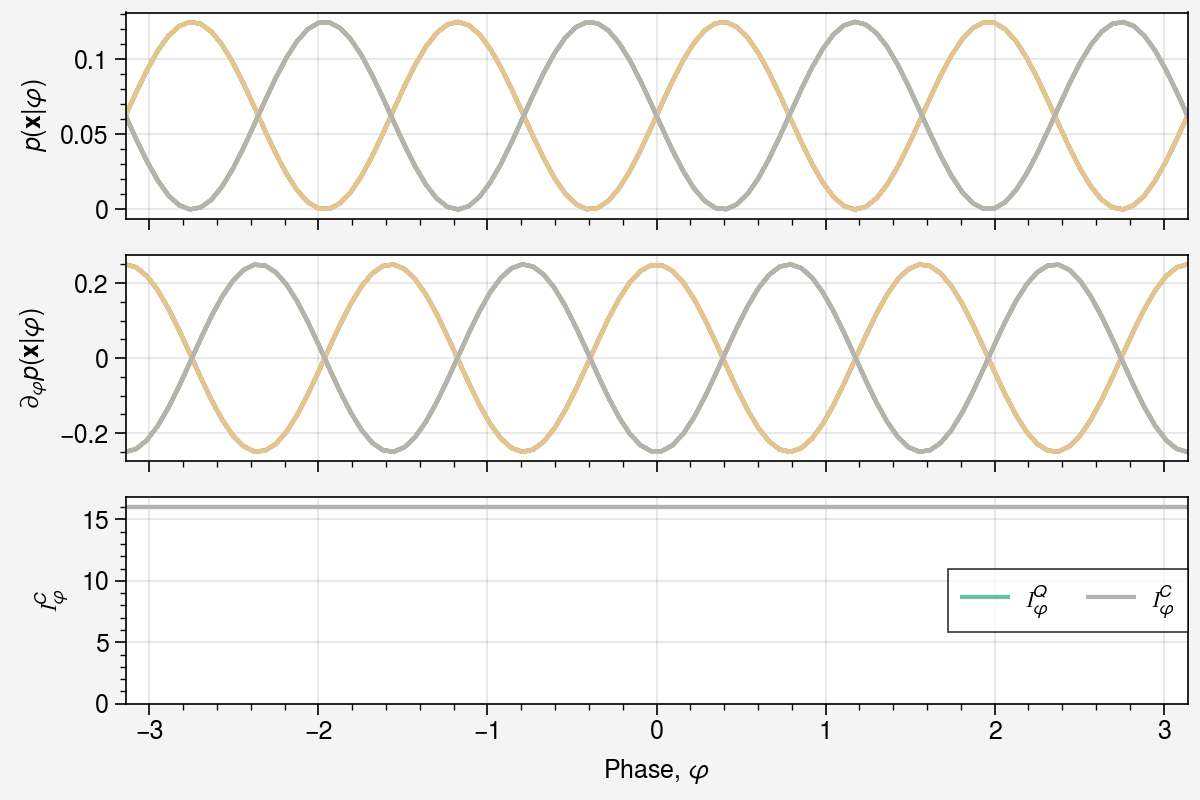

In [ ]:
colors = sns.color_palette("Set2", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, axs = uplt.subplots(nrows=3, figsize=(6, 4), sharey=False)

for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    axs[0].plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
    
    axs[1].plot(phis, grads[:, *idx], label=f"{idx}", color=colors[i])

axs[0].set(ylabel=r"$p(\mathbf{x} | \varphi)$")
axs[1].set(ylabel=r"$\partial_{\varphi} p(\mathbf{x} | \varphi)$")

axs[2].plot(phis, qfims.squeeze(), color=colors[0], label=r"$\mathcal{I}_\varphi^Q$")
axs[2].plot(phis, cfims.squeeze(), color=colors[-1], label=r"$\mathcal{I}_\varphi^C$")
axs[2].set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)
axs[2].legend();